In [1]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import yfinance as yf

c:\Users\Yassine\Desktop\Deepl learning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)


# M4

In [2]:
index = [0, 10, 200, 400, 300]

In [3]:
m4_df = pd.read_csv('../../Hourly-train.csv').iloc[index, 1:101]
m4_df

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101
0,605.0,586.0,586.0,559.0,511.0,443.0,422.0,395.0,382.0,370.0,...,707.0,718.0,733.0,741.0,737.0,710.0,647.0,593.0,564.0,528.0
10,41889.0,41145.0,40629.0,40281.0,39751.0,39532.0,38082.0,34916.0,31486.0,28989.0,...,26730.0,27764.0,28988.0,30145.0,31105.0,31887.0,32703.0,33125.0,33206.0,32732.0
200,12.6,11.8,11.3,11.0,10.6,10.3,10.1,11.3,13.2,14.9,...,19.4,18.4,16.8,15.4,14.5,13.8,13.5,12.6,12.1,11.7
400,17.0,20.0,12.0,15.0,11.0,13.0,13.0,12.0,18.0,24.0,...,52.0,30.0,24.0,24.0,22.0,16.0,14.0,12.0,14.0,14.0
300,12.6,12.1,11.6,11.2,10.8,10.6,10.2,10.1,11.4,13.2,...,20.1,18.2,16.3,15.0,14.2,13.6,12.9,12.4,11.9,11.5


In [5]:

quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(m4_df.iloc[:, :72].values),
    prediction_length=12,
    quantile_levels=[0.1, 0.5, 0.9],
)

c:\Users\Yassine\Desktop\Deepl learning\chronos-forecasting\src\chronos\chronos.py:189: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  torch.bucketize(


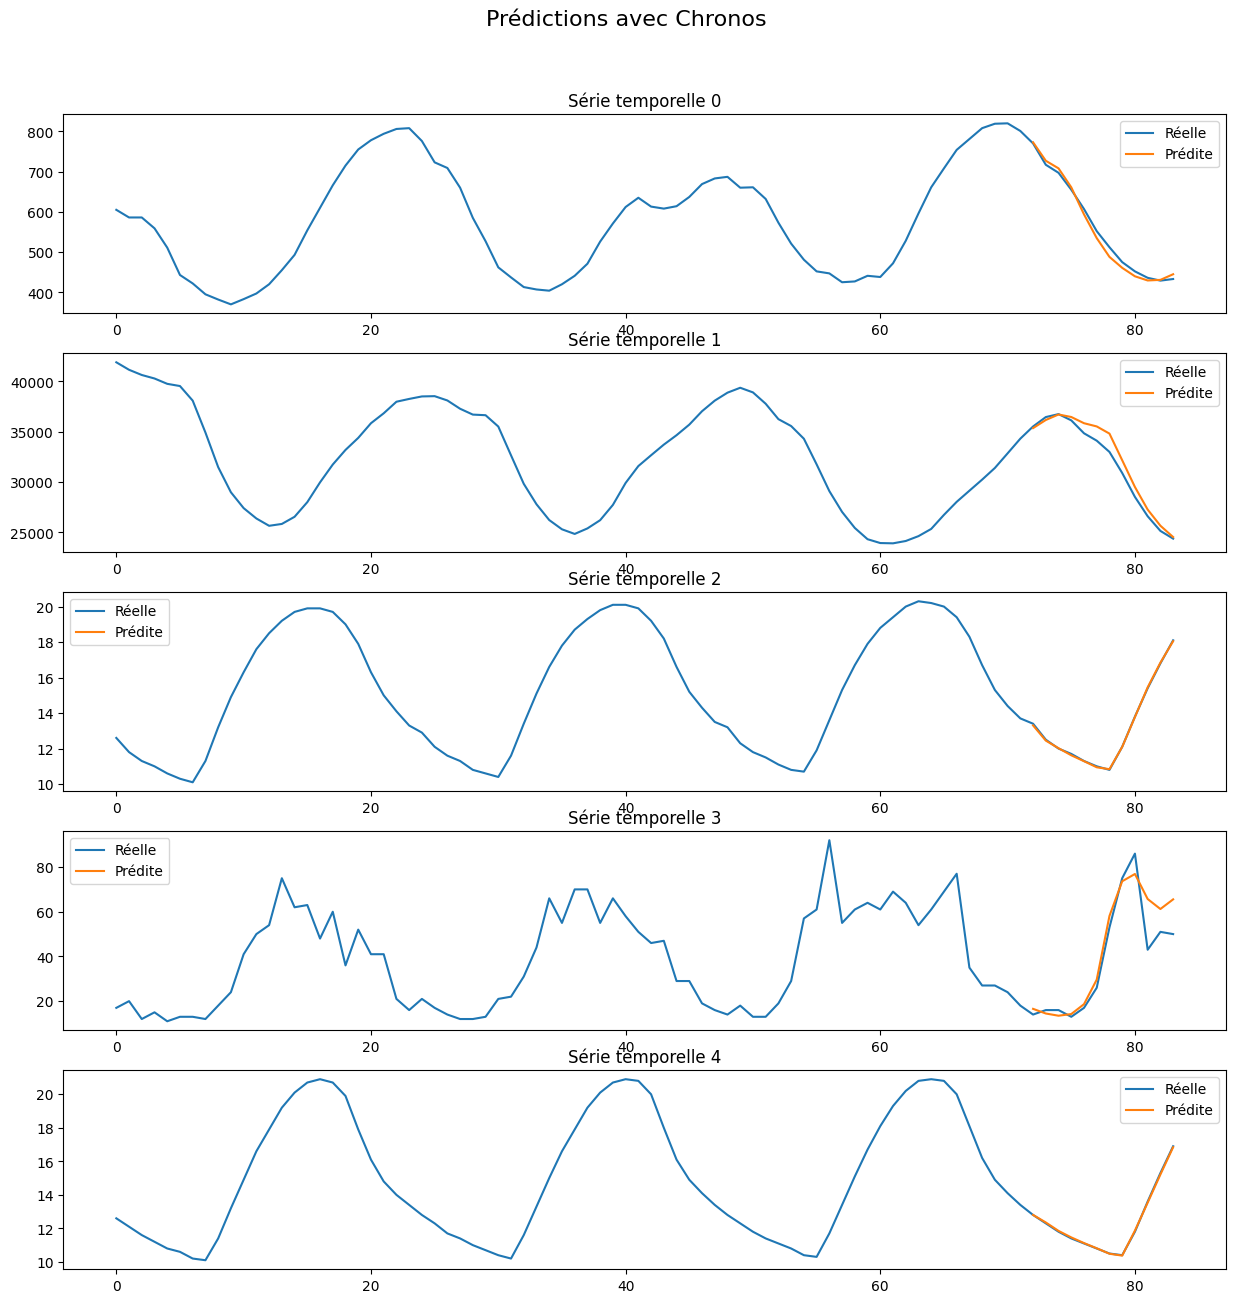

In [7]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(5, 1, figsize = (15, 15))
fig.suptitle("Prédictions avec Chronos", fontsize=16, y=0.95)
for i in range(5):
    ax[i].plot(np.arange(72+12), m4_df.iloc[i, :72+12].values, label = 'Réelle')
    ax[i].plot(np.arange(72, 72+12), mean[i], label = 'Prédite')
    ax[i].set_title(f'Série temporelle {i}')
    ax[i].legend()
plt.show()

In [8]:
mae = np.abs(m4_df.iloc[:, 72:72+12].values - mean.numpy()).mean(axis=1)
mae

array([1.09388657e+01, 7.20057454e+02, 4.31681792e-02, 6.42987768e+00,
       4.31467851e-02])

# Finance

In [11]:
indices = {
    'NASDAQ': '^IXIC',
    'CAC40': '^FCHI',
    'S&P500': '^GSPC'
}


start_date = (pd.Timestamp.now() - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

data = {}
for name, symbol in indices.items():
    df = yf.download(symbol, start=start_date, end=end_date, progress=False)
    data[name] = df['Close']


In [35]:
preds = []
for df in tqdm(data):
    _, pred = pipeline.predict_quantiles(
        context=torch.tensor(data[df].iloc[-62-31:-31].values[:, 0]),
        prediction_length=31,
        quantile_levels=[0.5],
    )
    preds.append(pred)

100%|██████████| 3/3 [01:33<00:00, 31.06s/it]


In [39]:
mae = []
for i, df in enumerate(data) :
    mae.append(np.mean(np.abs(data[df].iloc[-31:].values[:, 0]-preds[i].numpy()), axis=1))
mae

[array([317.49640877]), array([84.70180192]), array([71.1219443])]

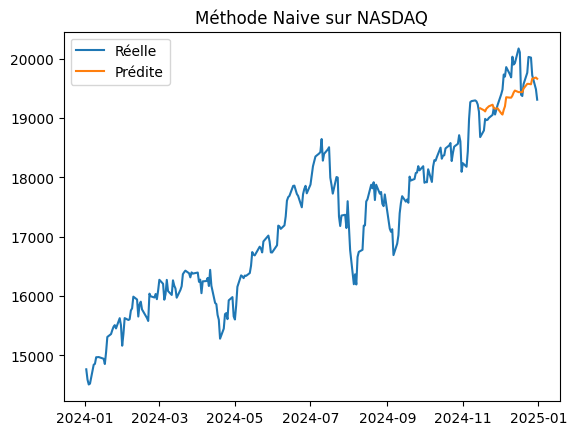

In [58]:
plt.plot(data['NASDAQ'].index, data['NASDAQ'].values, label = 'Réelle')
plt.plot(data['NASDAQ'].index[-31:], preds[0][0], label = 'Prédite')
plt.title(f'Méthode Naive sur NASDAQ')
plt.legend()
plt.show()

# Traffic

In [60]:
traffic_df = pd.read_csv('../../istanbul_traffic.csv', index_col = 'datetime').iloc[-1000:]
traffic_df = traffic_df.ffill()
traffic_df

,TI,TI_An,TI_Av
datetime,,,
2024-06-13 21:42:00,42,35,45
2024-06-13 21:43:00,42,35,45
2024-06-13 21:44:00,42,35,45
2024-06-13 21:45:00,42,36,45
2024-06-13 21:46:00,42,36,45
...,...,...,...
2024-06-16 12:25:00,20,17,22
2024-06-16 12:26:00,20,17,22
2024-06-16 12:27:00,20,17,22


In [64]:
traffic_tensor = torch.tensor(traffic_df.values).T
traffic_tensor.shape

torch.Size([3, 1000])

In [65]:
_, preds2 = pipeline.predict_quantiles(
    context=traffic_tensor[:, :900],
    prediction_length=100,
    quantile_levels=[0.5],
)

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


In [69]:
mae = torch.mean(torch.abs((traffic_tensor[:, 900:]-preds2)), axis=1)
mae

tensor([5.3016, 5.9028, 4.4560])

In [71]:
traffic_df.TI.values.shape

(1000,)

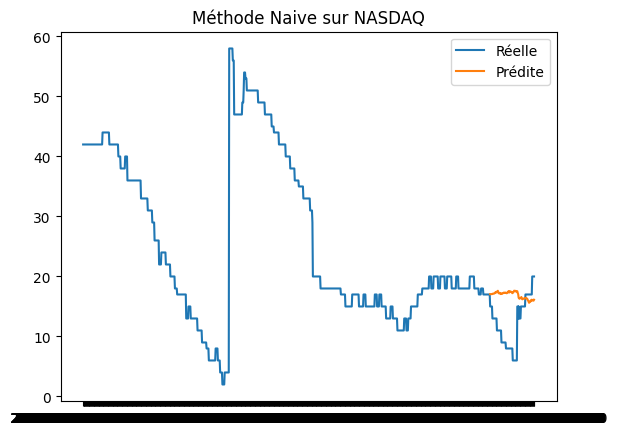

In [73]:
plt.plot(traffic_df.index, traffic_df.TI.values, label = 'Réelle')
plt.plot(traffic_df.index[-100:], preds2[0], label = 'Prédite')
plt.title(f'Méthode Naive sur IST Traffic')
plt.legend()
plt.show()

# ERCOT (electricity)

In [74]:
def get_ercot():
    url = "https://github.com/ourownstory/neuralprophet-data/raw/main/datasets_raw/energy/ERCOT_load_2004_2021Sept.csv"
    df = pd.read_csv(url).rename(columns = {'y' : 'target'})
    df['ds'] = pd.to_datetime(df['ds'])
    df.ffill(inplace=True)
    ercot_df = df[['ds', 'target']]
    ercot_df['target'] = (ercot_df['target']).astype('float64')
    ercot_df = ercot_df.set_index('ds')
    return ercot_df

In [75]:
ercot_df = get_ercot()
ercot_df

C:\Users\Yassine\AppData\Local\Temp\ipykernel_2060\938499966.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ercot_df['target'] = (ercot_df['target']).astype('float64')


,target
ds,
2004-01-01 01:00:00,22971.94
2004-01-01 02:00:00,22191.52
2004-01-01 03:00:00,21383.44
2004-01-01 04:00:00,20866.56
2004-01-01 05:00:00,20723.15
...,...
2021-08-31 20:00:00,69201.17
2021-08-31 21:00:00,67180.74
2021-08-31 22:00:00,63860.12


In [76]:
window_size = 744 + 24

windows = []
start_indices = np.arange(0, 3 * window_size, window_size)

for start in start_indices:
    window = ercot_df.iloc[start : start + window_size]
    windows.append(window.reset_index(drop=True)["target"]) 

final_df = pd.DataFrame({f"window_{i+1}": windows[i] for i in range(len(windows))})
final_df = final_df.set_index(pd.date_range("2023-01-01", periods=len(final_df), freq='H'))
final_df


,window_1,window_2,window_3
2023-01-01 00:00:00,22971.94,24763.41,23070.37
2023-01-01 01:00:00,22191.52,24478.03,22209.01
2023-01-01 02:00:00,21383.44,24692.61,21692.63
2023-01-01 03:00:00,20866.56,25325.55,21635.63
2023-01-01 04:00:00,20723.15,26587.99,22201.72
...,...,...,...
2023-02-01 19:00:00,29311.82,31201.36,31980.78
2023-02-01 20:00:00,29196.86,30723.60,30883.87
2023-02-01 21:00:00,28721.74,29415.37,28402.14
2023-02-01 22:00:00,28016.89,27181.40,25501.23


In [79]:
ercot_tensor = torch.tensor(final_df.values).T
ercot_tensor.shape

torch.Size([3, 768])

In [ ]:
_, preds2    = pipeline.predict_quantiles(
    context=ercot_tensor[:, :744],
    prediction_length=24,
    quantile_levels=[0.5],
)

In [87]:
mae = (preds2-ercot_tensor[:, 744:744+24]).abs().mean(axis=1)
mae

tensor([1098.1907,  425.5180,  928.6514], dtype=torch.float64)

In [89]:
final_df.values.shape

(768, 3)

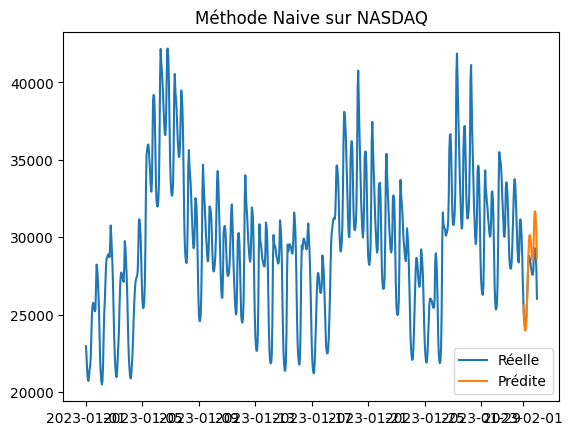

In [92]:
plt.plot(final_df.index, final_df.values[:, 0], label = 'Réelle')
plt.plot(final_df.index[-24:], preds2[0], label = 'Prédite')
plt.title(f'Méthode Naive sur ERCOT')
plt.legend()
plt.show()